# Import Libraries

In [1]:
import pandas as pd
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import nltk
import warnings
warnings.filterwarnings('ignore')

from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from keras.models import load_model

factory = StemmerFactory()
stemmer = factory.create_stemmer()
list_stopwords = set(stopwords.words('indonesian'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Data overview after preprocessing

In [2]:
df = pd.read_csv('final_cleaned_data.csv')
df.head()

,Text,Text_Cleansing,Text_Preprocessing,Sentiment
0,warung ini dimiliki oleh pengusaha pabrik tahu...,warung ini dimiliki oleh pengusaha pabrik tahu...,warung milik usaha pabrik puluh kenal putih ba...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,mohon ulama lurus dan k mmbri hujjah partai ap...,mohon ulama lurus k mmbri hujjah partai diwlh ...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,lokasi strategis di jalan sumatra bandung temp...,lokasi strategis jalan sumatra bandung nya nya...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,betapa bahagia nya diri ini saat unbog paket d...,betapa bahagia nya unbog paket barang nya bagu...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,aduh jadi mahasiswa jangan sombong dong kasih ...,aduh mahasiswa sombong kasih kartu kuning ajar...,negative


Cek Isi berdasarkan index

In [3]:
idx = 787
print('Teks Awal :',df['Text'][idx])
print('Teks Preprocessed :',df['Text_Preprocessing'][idx])

Teks Awal : kebaikan
Teks Preprocessed : baik


TF-IDF

In [18]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf = TfidfVectorizer()
# X = tfidf.fit_transform(df['Text_Preprocessing'].apply(lambda x: np.str_(x)))

In [19]:
# X

# Assign to specific x dan y

In [4]:
X = df['Text_Preprocessing'].astype(str)
max_features = 100000

# Tokenisasi
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)

# Padding
X = pad_sequences(X, maxlen=55)

# Menampilkan bentuk akhir dari data
X.shape

(11000, 55)

In [21]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("Tokenizer berhasil disimpan!")

Tokenizer berhasil disimpan!


In [22]:
import pickle

with open('Text_Preprocessing.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('Text_Preprocessing.pickle has created!')

Text_Preprocessing.pickle has created!


# Mapping and Assign Label y

In [5]:
# Dilakukan proses mapping karna label y > 2
sentiment_encode = {'negative' : 0, 'neutral' : 1, 'positive' : 2}
y = df['Sentiment'].map(sentiment_encode).values
print(y)
print(y.shape)

[2 1 2 ... 1 0 2]
(11000,)


# One Hot Encoder

In [6]:
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder()
onehot.fit(y.reshape(-1,1))
# y_hot = onehot.transform(y.reshape(-1,1))
y_hot = onehot.transform(y.reshape(-1,1)).toarray()
print(y_hot.shape)

(11000, 3)


In [25]:
# Cek Array y_hot 1-10
y_hot[0:10]

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [26]:
import pickle

with open('y_label.pickle', 'wb') as handle:
    pickle.dump(y_hot, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('y_label.pickle has created!')

y_label.pickle has created!


# Splitting Data

In [27]:
# from sklearn.model_selection import train_test_split

# file = open("x_pad_sequences.pickle",'rb')
# X = pickle.load(file)
# file.close()

# file = open("y_labels.pickle",'rb')
# y_hot = pickle.load(file)
# file.close()

# X_train, X_test, y_train, y_test = train_test_split(X, y_hot, test_size=0.2, random_state=1)

In [7]:
#dataset split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y_hot, test_size=0.20, random_state=1)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(8800, 55) (8800, 3)
(2200, 55) (2200, 3)


# Modelling

### 1. LSTM (Long Short Term Memory)

a. Arsitektur Model LSTM

In [8]:
X.shape[1]

55

In [12]:
epoch = 100
embed_dim = 25
maxlen = 55
# max_features = 100000

# Model LSTM
model_lstm = tf.keras.models.Sequential([ # inisialisasi model
    tf.keras.layers.Embedding(input_dim=max_features, output_dim=embed_dim, input_length=maxlen), # memetakan text ke dalam vektor
    # tf.keras.layers.LSTM(128, return_sequences=True), # hidden layer 1
    tf.keras.layers.LSTM(64, activation='tanh'), # hidden layer 2
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(3, activation='softmax') # layer output
])

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False) # mendefinisikan loss function

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', # Memantau val_loss pada data validasi
    mode='min', # Proses pelatihan akan berhenti ketika val_loss tidak berkurang
    verbose=1, # Menampilkan pesan ketika Early Stopping diaktifkan
    patience=15, # Pelatihan akan berhenti jika val_loss tidak membaik setelah 50 epoch
    restore_best_weights=True
)

# adam = tf.optimizers.Adam(learning_rate=0.0001) # Defini optimizer Adam (Adaptive Moment Estimation)
sgd = tf.keras.optimizers.SGD(learning_rate=0.075) # Defini optimizer SGD (Stochastic Gradient Descent)

model_lstm.compile(optimizer='sgd',
              loss=loss_fn,
              metrics=['accuracy'])


model_lstm.summary() # summary model

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

b. Training

In [30]:
history = model_lstm.fit(
    X_train,
    y_train,
    epochs = epoch,
    validation_data = (X_val, y_val),
    callbacks=[es],
    batch_size=64,
    verbose=1,
    )

Epoch 1/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 25s 112ms/step - accuracy: 0.5784 - loss: 1.0253 - val_accuracy: 0.5859 - val_loss: 0.9316
Epoch 2/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 19s 98ms/step - accuracy: 0.5802 - loss: 0.9267 - val_accuracy: 0.5859 - val_loss: 0.9144
Epoch 3/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 14s 104ms/step - accuracy: 0.5854 - loss: 0.9130 - val_accuracy: 0.5859 - val_loss: 0.9105
Epoch 4/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 20s 99ms/step - accuracy: 0.5900 - loss: 0.9017 - val_accuracy: 0.5859 - val_loss: 0.9066
Epoch 5/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 25s 130ms/step - accuracy: 0.5856 - loss: 0.8956 - val_accuracy: 0.5859 - val_loss: 0.8988
Epoch 6/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step - accuracy: 0.5802 - loss: 0.8987 - val_accuracy: 0.5859 - val_loss: 0.8813
Epoch 7/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - accuracy: 0.5751 - loss: 0.8841 - val_accuracy: 0.6086 - val_loss: 0.8245
Epoch 8/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 12s 83ms/step - accuracy: 0.6253 - loss

In [31]:
result = history.history
n_epochs = np.arange(0, len(result['accuracy']))


c. Plot Accuracy Epoch (LSTM)

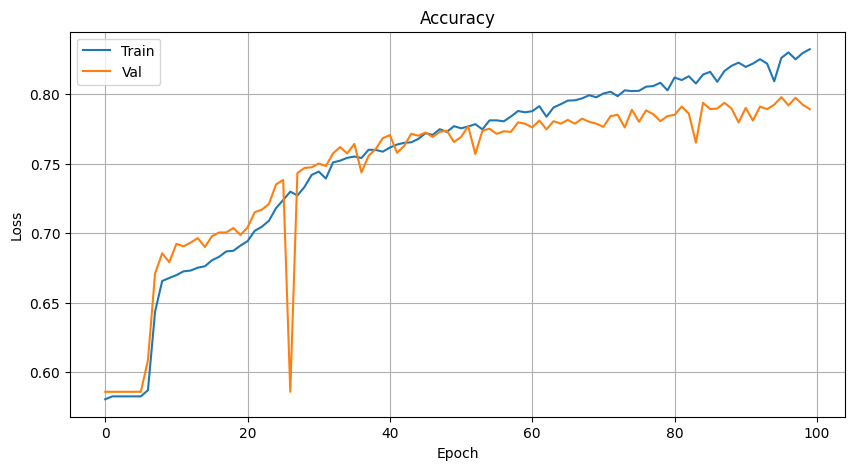

In [32]:
plt.figure(figsize=(10,5))
plt.title('Accuracy')
plt.plot(n_epochs, result['accuracy'])
plt.plot(n_epochs, result['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'])
plt.grid()
plt.show()

d. Plot Loss Epoch (LSTM)

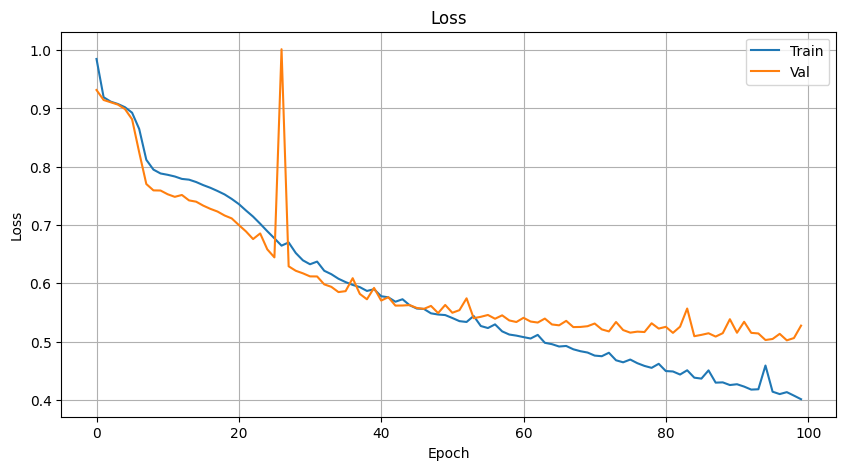

In [33]:
plt.figure(figsize=(10,5))
plt.title('Loss')
plt.plot(n_epochs, result['loss'])
plt.plot(n_epochs, result['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'])
plt.grid()
plt.show()

e. Evaluasi (LSTM)

In [34]:
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

y_pred = model_lstm.predict(X_val)

y_pred_classes = y_pred.argmax(axis=1)
y_val_classes = y_val.argmax(axis=1)
print("Testing selesai")
print(classification_report(y_val_classes, y_pred_classes, zero_division=0.0))

accuracy = accuracy_score(y_val_classes, y_pred_classes)
print('Accuracy Score SDG (0.00075) :', round(accuracy, 2))


69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.64      0.82      0.72       672
           1       0.83      0.15      0.25       239
           2       0.90      0.91      0.90      1289

    accuracy                           0.80      2200
   macro avg       0.79      0.62      0.62      2200
weighted avg       0.81      0.80      0.78      2200

Accuracy Score SDG (0.00075) : 0.8


f. Evaluasi (Cross-valid)

In [35]:
# Untuk lebih menyakinkan lagi, kita juga bisa melakukan "Cross Validation"
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=5,random_state=1,shuffle=True)

accuracies = []

label = y_hot

for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = label[data[0]]

    data_test    = X[data[1]]
    target_test  = label[data[1]]


    model_lstm.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.075),
    loss='CategoricalCrossentropy',
    metrics=['accuracy'])

    history = model_lstm.fit(
    data_train,
    target_train,
    epochs = 100,
    validation_data = (data_test, target_test),
    callbacks=[es],
    batch_size=64,
    verbose=1,
    )

    predictions = model_lstm.predict(X_val)
    y_pred = predictions

    # for the current fold only
    accuracy = accuracy_score(y_val.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_val.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

# this is the average accuracy over all folds
average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", round(average_accuracy,2))

Epoch 1/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 16s 80ms/step - accuracy: 0.7254 - loss: 0.7133 - val_accuracy: 0.7855 - val_loss: 0.5100
Epoch 2/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.7722 - loss: 0.5460 - val_accuracy: 0.7705 - val_loss: 0.5834
Epoch 3/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.7982 - loss: 0.4589 - val_accuracy: 0.7591 - val_loss: 0.6026
Epoch 4/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.8110 - loss: 0.4382 - val_accuracy: 0.8018 - val_loss: 0.4967
Epoch 5/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.8256 - loss: 0.4207 - val_accuracy: 0.7982 - val_loss: 0.5095
Epoch 6/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.8413 - loss: 0.3898 - val_accuracy: 0.7509 - val_loss: 0.6134
Epoch 7/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.8291 - loss: 0.4089 - val_accuracy: 0.8109 - val_loss: 0.4762
Epoch 8/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.8394 - loss: 0

# Save Model

In [36]:
model_lstm.save('lstm_model.h5')
print("Model berhasil disimpan!")

Model berhasil disimpan!


In [37]:
model_lstm.save('lstm_model.keras')
print("Model berhasil disimpan!")

Model berhasil disimpan!


g. Predict

In [38]:
# Memuat model
model_lstm = load_model('lstm_model.h5')

# Memuat tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

def cleansing(text):
    text = re.sub(r'\\t|\\n|\\u', ' ', text) #Menghapus karakter khusus seperti tab, baris baru, karakter Unicode, dan backslash.
    text = re.sub(r"https?:[^\s]+", ' ', text)  # Menghapus http / https
    text = re.sub(r'(\b\w+)-\1\b', r'\1', text)
    text = re.sub(r'[\\x]+[a-z0-9]{2}', '', text)  # Menghapus karakter yang dimulai dengan '\x' diikuti oleh dua karakter huruf atau angka
    # text = re.sub(r'(\d+)', r' \1 ', text)  # Memisahkan angka dari teks
    text = re.sub(r'[^a-zA-Z]+', ' ', text)  # Menghapus karakter kecuali huruf, dan spasi
    text = re.sub(r'\brt\b|\buser\b', ' ', text) # Menghapus kata-kata 'rt' dan 'user'
    text = text.lower()
    return text

class_labels = ['negatif', 'netral', 'positif']

original_text = 'babi lo prab*w* anjing gua sumpahin kamu mati saja . dasar sampah masyarakat .1234'
cleaned_text = cleansing(original_text)
print("Original text:", original_text)
print("Cleaned text:", cleaned_text)

text_sequence = tokenizer.texts_to_sequences([cleaned_text])
text_padded = pad_sequences(text_sequence, maxlen=55)

result = model_lstm.predict(text_padded)[0]
predicted_class = np.argmax(result)
predicted_label = class_labels[predicted_class]

print('Sentiment :')
print(predicted_label)

Original text: babi lo prab*w* anjing gua sumpahin kamu mati saja . dasar sampah masyarakat .1234
Cleaned text: babi lo prab w anjing gua sumpahin kamu mati saja dasar sampah masyarakat 
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step
Sentiment :
negatif
